# CFG Tester Code

### Required Libraries

In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt

### Read Graph Infor from JSON

In [2]:
def readGraphFromJSON(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)

    edges = data['edges']
    nodes = data['nodes']
    initial_nodes = data['initial_nodes']
    end_nodes = data['end_nodes']

    return edges, nodes, initial_nodes, end_nodes

file_path = 'Graphs/Graph1.json'
edges, nodes, initial_nodes, end_nodes = readGraphFromJSON(file_path)

### Create a directed graph

In [3]:
def define_graph(edges, nodes, initial_nodes, end_nodes):
    # Create an empty graph
    graph = nx.DiGraph()
    
    # Add nodes to the graph
    graph.add_nodes_from(nodes)
    
    # Add edges to the graph
    graph.add_edges_from(edges)
    
    return graph, initial_nodes, end_nodes


graph, initial_nodes, end_nodes = define_graph(edges, nodes, initial_nodes, end_nodes)

### Plot graph

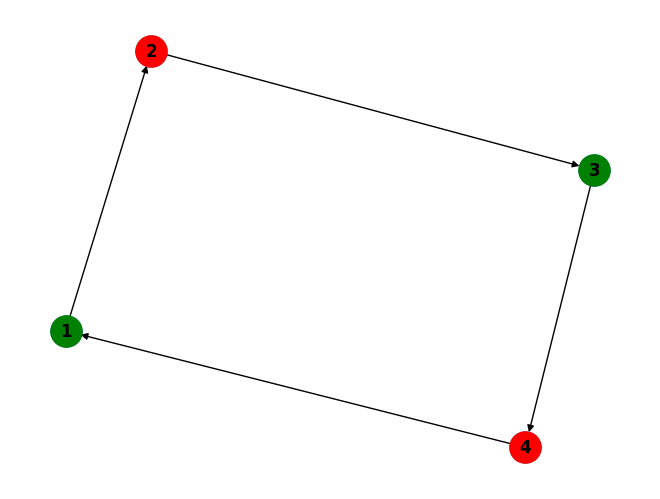

In [4]:
pos = nx.spring_layout(graph)  # Positions of the nodes
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=12, font_weight='bold')

# Draw start and end nodes with different colors
nx.draw_networkx_nodes(graph, pos, nodelist=initial_nodes, node_color='green', node_size=500)
nx.draw_networkx_nodes(graph, pos, nodelist=end_nodes, node_color='red', node_size=500)

plt.show()

### Extract Prime Paths

In [5]:
def isPrimePath(path, graph):
    if len(path) >= 2 and path[0] == path[-1]:
        return True
    elif reachedHead(path, graph) and reachedEnd(path, graph):
        return True
    else:
        return False


def reachedHead(path, graph):
    former_nodes = [n for n in graph.predecessors(path[0])]
    for n in former_nodes:
        if n not in path or n == path[-1]:
            return False
    return True


def reachedEnd(path, graph):
    later_nodes = [n for n in graph.successors(path[-1])]
    for n in later_nodes:
        if n not in path or n == path[0]:
            return False
    return True


def extendable(path, graph):
    if isPrimePath(path, graph) or reachedEnd(path, graph):
        return False
    else:
        return True


def findSimplePath(graph, exPaths, paths=[]):
    paths.extend(filter(lambda p: isPrimePath(p, graph), exPaths))
    exPaths = filter(lambda p: extendable(p, graph), exPaths)
    newExPaths = []
    for p in exPaths:
        for nx in graph.successors(p[-1]):
            if nx not in p or nx == p[0]:
                newExPaths.append(p + (nx,))
    if len(newExPaths) > 0:
        findSimplePath(graph, newExPaths, paths)


def findPrimePaths(graph):
    exPaths = [(n,) for n in graph.nodes()]
    simplePaths = []
    findSimplePath(graph, exPaths, simplePaths)
    primePaths = sorted(simplePaths, key=lambda a: (len(a), a))
    return primePaths

In [6]:
prime_paths = findPrimePaths(graph)
for p in prime_paths:
    print(list(p))

[1, 2, 3, 4, 1]
[2, 3, 4, 1, 2]
[3, 4, 1, 2, 3]
[4, 1, 2, 3, 4]


### Test Paths

In [7]:
def getTestPaths(prime_paths):
    test_paths = []

    for i in range(len(prime_paths)):
        current_path = prime_paths[i]

        # If the current prime path is a test path, add it to the result
        if isTestPath(current_path):
            test_paths.append(current_path)
            continue

        for j in range(len(prime_paths)):
            if i != j:
                other_path = prime_paths[j]
                merged_path, is_mergeable = merge_paths(current_path, other_path)

                if is_mergeable and isTestPath(merged_path):
                    test_paths.append(merged_path)

    return test_paths


def isTestPath(path):
    if len(path) < 2:
        return False
    
    if path[0] not in initial_nodes or path[-1] not in end_nodes:
        return False
    
    for i in range(len(path) - 1):
        if not graph.has_edge(path[i], path[i+1]):
            return False
    
    return True


def merge_paths(path1, path2):
    k = min(len(path1), len(path2))
    while k >= 1:
        if path1[-k:] == path2[:k]:
            merged_path = path1 + path2[k:]
            return merged_path, True
        k -= 1
    merged_path = path1
    return merged_path, False

In [8]:
test_paths = getTestPaths(prime_paths)
if len(test_paths) > 0:
    print("Count:", len(test_paths))
    print("Test Paths:", test_paths)
else:
    print("No test paths can be found")

Count: 4
Test Paths: [(1, 2, 3, 4, 1, 2), (1, 2, 3, 4, 1, 2, 3, 4), (3, 4, 1, 2, 3, 4, 1, 2), (3, 4, 1, 2, 3, 4)]


### Convert tuples to lists

In [9]:
prime_paths = [list(t) for t in prime_paths]
test_paths = [list(t) for t in test_paths]

print("Prime Paths:", prime_paths)
print("Test Paths:", test_paths)

Prime Paths: [[1, 2, 3, 4, 1], [2, 3, 4, 1, 2], [3, 4, 1, 2, 3], [4, 1, 2, 3, 4]]
Test Paths: [[1, 2, 3, 4, 1, 2], [1, 2, 3, 4, 1, 2, 3, 4], [3, 4, 1, 2, 3, 4, 1, 2], [3, 4, 1, 2, 3, 4]]


### Prime Path Coverage

In [10]:
def convert_to_strings(list_of_lists):
    result = []
    for inner_list in list_of_lists:
        string_representation = '-'.join(map(str, inner_list))
        result.append(string_representation)
    return result


def prime_path_coverage(prime_paths, test_paths):
    ppaths = convert_to_strings(prime_paths)
    tpaths = convert_to_strings(sorted(test_paths, key=len))

    covered_paths = set()
    tests = set()

    for tp in tpaths:
        for pp in ppaths:
            if pp in tp:
                covered_paths.add(pp)
                tests.add(tp)

                if len(covered_paths) == len(prime_paths):
                    return tests

In [11]:
covered_paths = prime_path_coverage(prime_paths, test_paths)
print(len(covered_paths))
print(covered_paths)

2
{'1-2-3-4-1-2', '3-4-1-2-3-4'}
